# NOTEBOOK 04: RECOMMENDATION SYSTEM

## CELL 1: SETUP & DATA LOADING
* M·ª•c ti√™u:
    * X√¢y d·ª±ng h·ªá th·ªëng g·ª£i √Ω s·∫£n ph·∫©m (item-based collaborative filtering)
    * S·ª≠ d·ª•ng Cosine similarity tr√™n ma tr·∫≠n t∆∞∆°ng t√°c ng∆∞·ªùi d√πng - s·∫£n ph·∫©m
    * M·ª•c ti√™u kinh doanh:TƒÉng cross-sell, c·∫£i thi·ªán tr·∫£i nghi·ªám kh√°ch h√†ng, tƒÉng AOV (Average Order Value)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("üí° PRODUCT RECOMMENDATION SYSTEM")
print("="*60)

# ============================================
# 1. LOAD ALL NECESSARY DATA
# ============================================
print("\n1Ô∏è‚É£ Loading data...")

# Load datasets
customers = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/olist_customers_dataset.csv')
orders = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/olist_orders_dataset.csv')
order_items = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/olist_order_items_dataset.csv')
products = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/olist_products_dataset.csv')

print(f"   ‚úÖ Customers: {len(customers):,} records")
print(f"   ‚úÖ Orders: {len(orders):,} records")
print(f"   ‚úÖ Order Items: {len(order_items):,} records")
print(f"   ‚úÖ Products: {len(products):,} records")

# ============================================
# 2. DATA PREPARATION
# ============================================
print("\n2Ô∏è‚É£ Preparing transaction data...")

# Merge to get customer-product interactions
transactions = order_items.merge(
    orders[['order_id', 'customer_id', 'order_status']], 
    on='order_id'
).merge(
    customers[['customer_id', 'customer_unique_id']], 
    on='customer_id'
)

# Filter only delivered orders
transactions = transactions[transactions['order_status'] == 'delivered']

print(f"   ‚úÖ Total transactions: {len(transactions):,}")
print(f"   ‚úÖ Unique customers: {transactions['customer_unique_id'].nunique():,}")
print(f"   ‚úÖ Unique products: {transactions['product_id'].nunique():,}")

# ============================================
# 3. DATA QUALITY CHECK
# ============================================
print("\n3Ô∏è‚É£ Data quality check...")

# Check for missing product_ids
missing_products = transactions['product_id'].isnull().sum()
print(f"   Missing product_ids: {missing_products}")

# Remove if any
transactions = transactions.dropna(subset=['product_id', 'customer_unique_id'])

# Basic stats
print(f"\nüìä Transaction Statistics:")
print(f"   Avg items per order: {transactions.groupby('order_id').size().mean():.2f}")
print(f"   Avg products per customer: {transactions.groupby('customer_unique_id')['product_id'].nunique().mean():.2f}")
print(f"   Total unique products: {transactions['product_id'].nunique():,}")

print("\n" + "="*60)

üí° PRODUCT RECOMMENDATION SYSTEM

1Ô∏è‚É£ Loading data...
   ‚úÖ Customers: 99,441 records
   ‚úÖ Orders: 99,441 records
   ‚úÖ Order Items: 112,650 records
   ‚úÖ Products: 32,951 records

2Ô∏è‚É£ Preparing transaction data...
   ‚úÖ Total transactions: 110,197
   ‚úÖ Unique customers: 93,358
   ‚úÖ Unique products: 32,216

3Ô∏è‚É£ Data quality check...
   Missing product_ids: 0

üìä Transaction Statistics:
   Avg items per order: 1.14
   Avg products per customer: 1.07
   Total unique products: 32,216



* Nh·∫≠n x√©t:
    * Ph·∫ßn l·ªõn kh√°ch h√†ng ch·ªâ mua 1 s·∫£n ph·∫©m.
    * Ma tr·∫≠n t∆∞∆°ng t√°c (user-item) s·∫Ω c·ª±c k·ª≥ th∆∞a ‚Üí sparsity ∆∞·ªõc t√≠nh > 99%.
* √ù nghƒ©a:
    * Item-based CF ph√π h·ª£p h∆°n user-based trong tr∆∞·ªùng h·ª£p n√†y.
    * Tuy nhi√™n, m√¥ h√¨nh s·∫Ω kh√≥ h·ªçc ra c√°c pattern r√µ r√†ng n·∫øu d·ªØ li·ªáu qu√° ph√¢n t√°n.
    * C·∫ßn l·ªçc ra c√°c s·∫£n ph·∫©m ph·ªï bi·∫øn ƒë·ªÉ tƒÉng ƒë·ªô tin c·∫≠y khi t√≠nh ƒë·ªô t∆∞∆°ng ƒë·ªìng.
* -> D·ªØ li·ªáu hi·ªán t·∫°i c√≥ ƒë·ªô th∆∞a r·∫•t cao ‚Äî ƒë√¢y l√† th√°ch th·ª©c ph·ªï bi·∫øn khi x√¢y d·ª±ng h·ªá th·ªëng g·ª£i √Ω th·ª±c t·∫ø. Tuy nhi√™n, item-based collaborative filtering v·∫´n c√≥ th·ªÉ ho·∫°t ƒë·ªông hi·ªáu qu·∫£ n·∫øu:
    * L·ªçc ra s·∫£n ph·∫©m ph·ªï bi·∫øn,
    * T·ªëi ∆∞u t√≠nh to√°n cosine similarity,
    * √Åp d·ª•ng chi·∫øn l∆∞·ª£c g·ª£i √Ω top-N.

## CELL 2: USER-ITEM MATRIX

* M·ª§C ƒê√çCH:
    * Lo·∫°i b·ªè c√°c s·∫£n ph·∫©m √≠t ng∆∞·ªùi mua ‚Üí gi√∫p h·ªá th·ªëng l·ªçc c·ªông t√°c ch·∫°y nhanh v√† ·ªïn ƒë·ªãnh.
    * T·∫°o ma tr·∫≠n t·ªëi ∆∞u ƒë·ªÉ t√≠nh ƒë·ªô t∆∞∆°ng ƒë·ªìng s·∫£n ph·∫©m.
* √ù nghƒ©a:
    * Ti·∫øt ki·ªám kho·∫£ng h∆°n 10Gb gram t·ª´ vi·ªác t·∫°o th·ª±c hi·ªán pivot (Bi·∫øn ƒë·ªïi b·∫£ng d·ªØ li·ªáu d·∫°ng d√†i (long format) th√†nh d·∫°ng ma tr·∫≠n (wide format)
    * Lo·∫°i b·ªè ~98% s·∫£n ph·∫©m ch·ªâ c√≥ r·∫•t √≠t ng∆∞·ªùi mua ‚Üí gi√∫p ma tr·∫≠n g·ªçn, d·ªÖ x·ª≠ l√Ω h∆°n r·∫•t nhi·ªÅu.

üî® BUILDING USER-ITEM MATRIX (MEMORY OPTIMIZED)

1Ô∏è‚É£ Creating interaction data...
   ‚úÖ Interaction records: 99,785
   ‚úÖ Unique customers: 93,358
   ‚úÖ Unique products: 32,216

2Ô∏è‚É£ Filtering popular products (BEFORE pivot to save memory)...

üìä Product Popularity Statistics:
   Total products: 32,216
   Products with 1 customer: 19,175
   Products with 2-4 customers: 8,958
   Products with 5-9 customers: 2,451
   Products with 10+ customers: 1,632
   Products with 20+ customers: 598
   Products with 50+ customers: 144

üîç Filtering Strategy:
   Minimum customers threshold: 20
   Products kept: 598
   Products removed: 31,618
   Retention rate: 1.86%

üìä After Filtering:
   Interactions: 28,446 (from 99,785)
   Customers: 27,829
   Products: 598

3Ô∏è‚É£ Estimating memory requirements...
   Matrix dimensions: 27,829 √ó 598
   Estimated memory: 0.12 GB

4Ô∏è‚É£ Creating pivot matrix...
   ‚è≥ This may take 1-2 minutes...
   ‚úÖ Matrix created successfully!
   ‚úÖ Shap

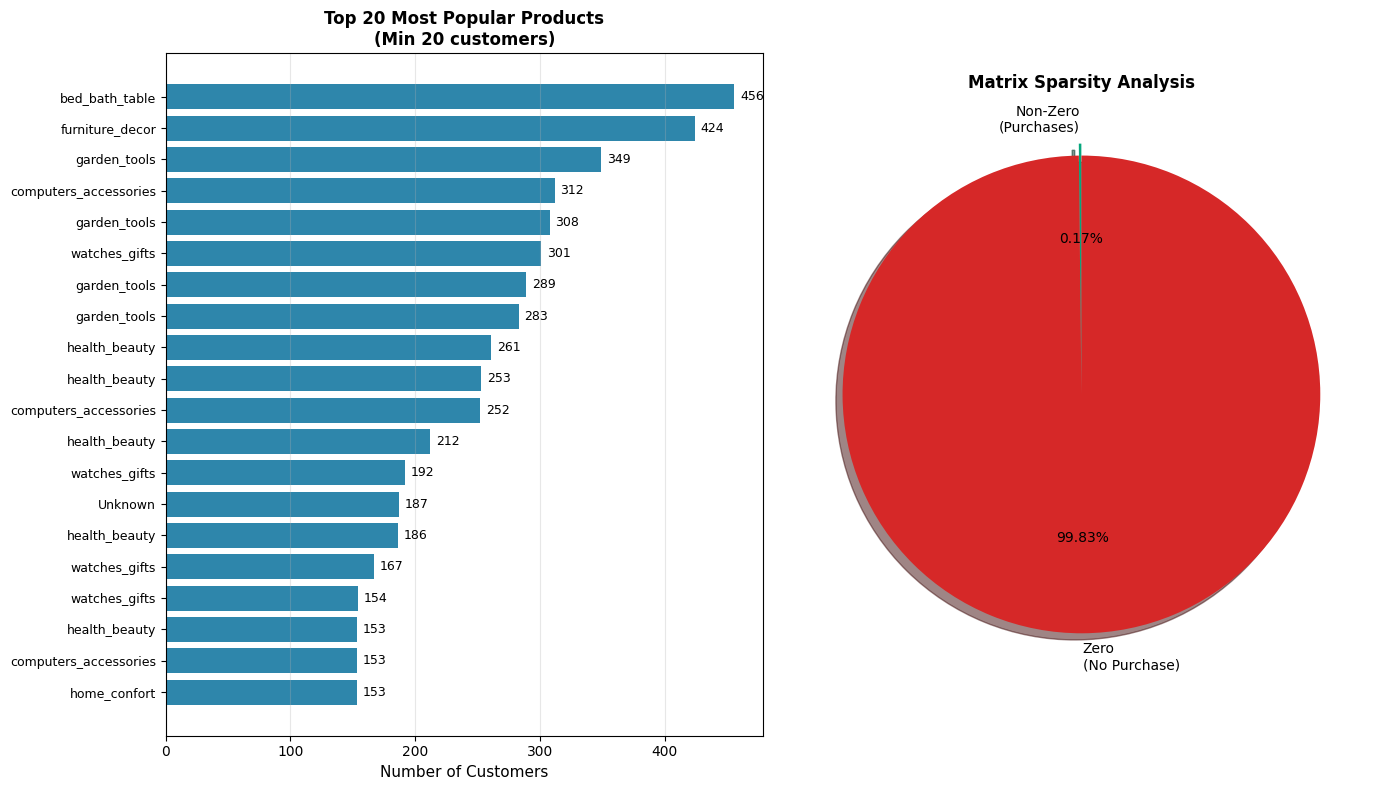

   ‚úÖ Visualization saved with product names

üìä Top 10 Most Popular Products:
 1. bed_bath_table                      - 456 customers
 2. furniture_decor                     - 424 customers
 3. garden_tools                        - 349 customers
 4. computers_accessories               - 312 customers
 5. garden_tools                        - 308 customers
 6. watches_gifts                       - 301 customers
 7. garden_tools                        - 289 customers
 8. garden_tools                        - 283 customers
 9. health_beauty                       - 261 customers
10. health_beauty                       - 253 customers

7Ô∏è‚É£ Saving user-item matrix...
   ‚úÖ Matrix saved: user_item_matrix.csv
   ‚úÖ Popular products list saved

‚úÖ USER-ITEM MATRIX READY

üìä Final Matrix:
   Shape: (27829, 598)
   Customers: 27,829
   Products: 598
   Sparsity: 99.83%
   Memory usage: 129.33 MB

üéØ Matrix optimized for similarity calculation
   Kept products with 20+ customers
   

In [2]:
print("="*60)
print("üî® BUILDING USER-ITEM MATRIX (MEMORY OPTIMIZED)")
print("="*60)

# ============================================
# 1. CREATE INTERACTION DATA
# ============================================
print("\n1Ô∏è‚É£ Creating interaction data...")

# Aggregate: How many times customer bought each product
user_item_data = transactions.groupby(
    ['customer_unique_id', 'product_id']
).agg({
    'order_item_id': 'count'
}).reset_index()

user_item_data.columns = ['customer_id', 'product_id', 'purchase_count']

print(f"   ‚úÖ Interaction records: {len(user_item_data):,}")
print(f"   ‚úÖ Unique customers: {user_item_data['customer_id'].nunique():,}")
print(f"   ‚úÖ Unique products: {user_item_data['product_id'].nunique():,}")

# ============================================
# 2. FILTER POPULAR PRODUCTS FIRST!
# ============================================
print("\n2Ô∏è‚É£ Filtering popular products (BEFORE pivot to save memory)...")

# Count customers per product
product_popularity = user_item_data.groupby('product_id')['customer_id'].nunique()
product_popularity = product_popularity.sort_values(ascending=False)

print(f"\nüìä Product Popularity Statistics:")
print(f"   Total products: {len(product_popularity):,}")
print(f"   Products with 1 customer: {(product_popularity == 1).sum():,}")
print(f"   Products with 2-4 customers: {((product_popularity >= 2) & (product_popularity <= 4)).sum():,}")
print(f"   Products with 5-9 customers: {((product_popularity >= 5) & (product_popularity <= 9)).sum():,}")
print(f"   Products with 10+ customers: {(product_popularity >= 10).sum():,}")
print(f"   Products with 20+ customers: {(product_popularity >= 20).sum():,}")
print(f"   Products with 50+ customers: {(product_popularity >= 50).sum():,}")

# CRITICAL: Filter to keep only popular products
MIN_CUSTOMERS = 20  # Increased threshold to reduce memory

popular_products = product_popularity[product_popularity >= MIN_CUSTOMERS].index.tolist()

print(f"\nüîç Filtering Strategy:")
print(f"   Minimum customers threshold: {MIN_CUSTOMERS}")
print(f"   Products kept: {len(popular_products):,}")
print(f"   Products removed: {len(product_popularity) - len(popular_products):,}")
print(f"   Retention rate: {len(popular_products)/len(product_popularity)*100:.2f}%")

# Filter interaction data
user_item_data_filtered = user_item_data[
    user_item_data['product_id'].isin(popular_products)
]

print(f"\nüìä After Filtering:")
print(f"   Interactions: {len(user_item_data_filtered):,} (from {len(user_item_data):,})")
print(f"   Customers: {user_item_data_filtered['customer_id'].nunique():,}")
print(f"   Products: {user_item_data_filtered['product_id'].nunique():,}")

# ============================================
# 3. ESTIMATE MEMORY BEFORE PIVOT
# ============================================
print("\n3Ô∏è‚É£ Estimating memory requirements...")

n_customers = user_item_data_filtered['customer_id'].nunique()
n_products = len(popular_products)
estimated_gb = (n_customers * n_products * 8) / (1024**3)  # 8 bytes per float64

print(f"   Matrix dimensions: {n_customers:,} √ó {n_products:,}")
print(f"   Estimated memory: {estimated_gb:.2f} GB")

if estimated_gb > 4:
    print(f"\n   ‚ö†Ô∏è  Still too large! Increasing threshold...")
    # Increase threshold more
    MIN_CUSTOMERS = 50
    popular_products = product_popularity[product_popularity >= MIN_CUSTOMERS].index.tolist()
    user_item_data_filtered = user_item_data[
        user_item_data['product_id'].isin(popular_products)
    ]
    n_products = len(popular_products)
    estimated_gb = (n_customers * n_products * 8) / (1024**3)
    print(f"   New threshold: {MIN_CUSTOMERS}")
    print(f"   Products kept: {len(popular_products):,}")
    print(f"   New estimated memory: {estimated_gb:.2f} GB")

# ============================================
# 4. CREATE PIVOT MATRIX (NOW SAFE!)
# ============================================
print("\n4Ô∏è‚É£ Creating pivot matrix...")
print("   ‚è≥ This may take 1-2 minutes...")

# Now pivot with filtered data
user_item_matrix = user_item_data_filtered.pivot(
    index='customer_id',
    columns='product_id',
    values='purchase_count'
).fillna(0)

print(f"   ‚úÖ Matrix created successfully!")
print(f"   ‚úÖ Shape: {user_item_matrix.shape}")
print(f"      Customers (rows): {user_item_matrix.shape[0]:,}")
print(f"      Products (columns): {user_item_matrix.shape[1]:,}")

# ============================================
# 5. MATRIX SPARSITY ANALYSIS
# ============================================
print("\n5Ô∏è‚É£ Matrix sparsity analysis...")

total_cells = user_item_matrix.shape[0] * user_item_matrix.shape[1]
non_zero_cells = (user_item_matrix > 0).sum().sum()
sparsity = (1 - non_zero_cells / total_cells) * 100

print(f"   Total cells: {total_cells:,}")
print(f"   Non-zero cells: {non_zero_cells:,}")
print(f"   Sparsity: {sparsity:.2f}%")
print(f"   Density: {100-sparsity:.2f}%")

# ============================================
# 6. VISUALIZATION
# ============================================
print("\n6Ô∏è‚É£ Creating visualizations...")

# First, get product names from products dataframe
# Merge to get actual product category names
product_names = products[['product_id', 'product_category_name']].drop_duplicates()

# Get top 20 products with names
top_20_products = product_popularity[product_popularity >= MIN_CUSTOMERS].head(20)
top_20_with_names = pd.DataFrame({
    'product_id': top_20_products.index,
    'customer_count': top_20_products.values
})

# Merge with product names
top_20_with_names = top_20_with_names.merge(
    product_names, 
    on='product_id', 
    how='left'
)

# If category name is missing or in Portuguese, use product_id
top_20_with_names['display_name'] = top_20_with_names['product_category_name'].fillna('Unknown')

# Load translation if available
try:
    category_translation = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/product_category_name_translation.csv')
    top_20_with_names = top_20_with_names.merge(
        category_translation,
        left_on='product_category_name',
        right_on='product_category_name',
        how='left'
    )
    # Use English name if available
    top_20_with_names['display_name'] = top_20_with_names['product_category_name_english'].fillna(
        top_20_with_names['product_category_name']
    ).fillna('Unknown')
except:
    print("   ‚ö†Ô∏è  Translation file not found, using Portuguese names")

# Truncate long names
top_20_with_names['display_name'] = top_20_with_names['display_name'].str[:30]

# Create visualization
plt.figure(figsize=(14, 8))

# Plot 1: Product popularity distribution with REAL NAMES
plt.subplot(1, 2, 1)
plt.barh(range(len(top_20_with_names)), 
         top_20_with_names['customer_count'].values, 
         color='#2E86AB')
plt.yticks(range(len(top_20_with_names)), 
           top_20_with_names['display_name'].values,
           fontsize=9)
plt.xlabel('Number of Customers', fontsize=11)
plt.title(f'Top 20 Most Popular Products\n(Min {MIN_CUSTOMERS} customers)', 
          fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(top_20_with_names['customer_count'].values):
    plt.text(v + max(top_20_with_names['customer_count'])*0.01, i, 
             str(int(v)), va='center', fontsize=9)

# Plot 2: Sparsity visualization
plt.subplot(1, 2, 2)
metrics = ['Non-Zero\n(Purchases)', 'Zero\n(No Purchase)']
values = [100-sparsity, sparsity]
colors = ['#06A77D', '#D62828']
explode = (0.05, 0)
plt.pie(values, labels=metrics, autopct='%1.2f%%', colors=colors, 
        startangle=90, explode=explode, shadow=True)
plt.title('Matrix Sparsity Analysis', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('D:/Project/DataMining/ecommerce-customer-analytics/reports/figures/recommendation_matrix_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ‚úÖ Visualization saved with product names")

# Print top 10 products with details
print("\nüìä Top 10 Most Popular Products:")
print("="*70)
for idx, row in top_20_with_names.head(10).iterrows():
    print(f"{idx+1:2d}. {row['display_name']:35s} - {int(row['customer_count']):,} customers")
print("="*70)

# ============================================
# 7. SAVE MATRIX
# ============================================
print("\n7Ô∏è‚É£ Saving user-item matrix...")

user_item_matrix.to_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/processed/user_item_matrix.csv')
print(f"   ‚úÖ Matrix saved: user_item_matrix.csv")

# Also save product list for reference
pd.DataFrame({'product_id': popular_products}).to_csv(
    'D:/Project/DataMining/ecommerce-customer-analytics/data/processed/popular_products.csv', index=False
)
print(f"   ‚úÖ Popular products list saved")

# ============================================
# 8. SUMMARY
# ============================================
print("\n" + "="*60)
print("‚úÖ USER-ITEM MATRIX READY")
print("="*60)
print(f"\nüìä Final Matrix:")
print(f"   Shape: {user_item_matrix.shape}")
print(f"   Customers: {user_item_matrix.shape[0]:,}")
print(f"   Products: {user_item_matrix.shape[1]:,}")
print(f"   Sparsity: {sparsity:.2f}%")
print(f"   Memory usage: {user_item_matrix.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"\nüéØ Matrix optimized for similarity calculation")
print(f"   Kept products with {MIN_CUSTOMERS}+ customers")
print(f"   Ready for collaborative filtering")
print("="*60)

* Ph√¢n t√≠ch k·∫øt qu·∫£:
1. D·ªØ li·ªáu g·ªëc:
    * T·ªïng l∆∞·ª£t mua: 99,785
    * Kh√°ch h√†ng duy nh·∫•t: 93,358
    * S·∫£n ph·∫©m duy nh·∫•t: 32,216
2. Ph√¢n b·ªë ƒë·ªô ph·ªï bi·∫øn s·∫£n ph·∫©m:
    * | S·ªë kh√°ch h√†ng mua | S·ªë s·∫£n ph·∫©m |
    * | ----------------- | ----------- |
    * | 1 kh√°ch h√†ng      | 19,175      |
    * | 2‚Äì4 kh√°ch h√†ng    | 8,958       |
    * | 5‚Äì9 kh√°ch h√†ng    | 2,451       |
    * | ‚â• 10 kh√°ch h√†ng   | 1,632       |
    * | ‚â• 20 kh√°ch h√†ng   | 598         |
    * | ‚â• 50 kh√°ch h√†ng   | 144         |
* -> √Åp d·ª•ng ng∆∞·ª°ng l·ªçc MIN_CUSTOMERS = 20 ‚Üí gi·ªØ l·∫°i 598 s·∫£n ph·∫©m (1.86%), lo·∫°i b·ªè 31,618 s·∫£n ph·∫©m √≠t t∆∞∆°ng t√°c.
* -> Gi·∫£m ƒë√°ng k·ªÉ k√≠ch th∆∞·ªõc ma tr·∫≠n, ti·∫øt ki·ªám t√†i nguy√™n t√≠nh to√°n.
3. Sau khi l·ªçc s·∫£n ph·∫©m:
    * L∆∞·ª£t mua c√≤n l·∫°i: 28,446
    * Kh√°ch h√†ng c√≤n l·∫°i: 27,829
    * S·∫£n ph·∫©m c√≤n l·∫°i: 598
* -> T·∫≠p d·ªØ li·ªáu nh·ªè g·ªçn nh∆∞ng v·∫´n ƒë·∫°i di·ªán t·ªët cho h√†nh vi th·ª±c t·∫ø.
4. Ma tr·∫≠n ng∆∞·ªùi d√πng ‚Äì s·∫£n ph·∫©m:
    * K√≠ch th∆∞·ªõc: 27,829 √ó 598
    * T·ªïng √¥: 16,641,742
    * √î c√≥ gi√° tr·ªã (c√≥ mua): 28,446
    * Sparsity: 99.83%
* -> ƒê√¢y l√† m·ªôt ma tr·∫≠n th∆∞a, ƒë·∫∑c tr∆∞ng ph·ªï bi·∫øn c·ªßa d·ªØ li·ªáu th∆∞∆°ng m·∫°i ƒëi·ªán t·ª≠.
* -> ƒê√£ ƒë∆∞·ª£c t·ªëi ∆∞u h√≥a ƒë·ªÉ d√πng cho collaborative filtering.
5. Top 10 s·∫£n ph·∫©m ph·ªï bi·∫øn nh·∫•t:
    * | STT | T√™n s·∫£n ph·∫©m (Danh m·ª•c) | Kh√°ch h√†ng |
    * | --- | ----------------------- | ---------- |
    * | 1   | bed_bath_table          | 456        |
    * | 2   | furniture_decor         | 424        |
    * | 3   | garden_tools            | 349        |
    * | 4   | computers_accessories   | 312        |
    * | 5   | garden_tools            | 308        |
    * | 6   | watches_gifts           | 301        |
    * | 7   | garden_tools            | 289        |
    * | 8   | garden_tools            | 283        |
    * | 9   | health_beauty           | 261        |
    * | 10  | health_beauty           | 253        |
* -> C√°c danh m·ª•c ph√≤ng ng·ªß ‚Äì ph√≤ng t·∫Øm, n·ªôi th·∫•t trang tr√≠ v√† d·ª•ng c·ª• l√†m v∆∞·ªùn c√≥ l∆∞·ª£ng mua cao nh·∫•t ‚Üí g·ª£i √Ω c√°c ph√¢n kh√∫c s·∫£n ph·∫©m ti·ªÅm nƒÉng ƒë·ªÉ x√¢y d·ª±ng h·ªá th·ªëng g·ª£i √Ω.
6. K·∫øt lu·∫≠n ch√≠nh:
    * Gi·∫£m m·∫°nh s·ªë s·∫£n ph·∫©m ‚Üí t·ª´ 32,216 c√≤n 598 s·∫£n ph·∫©m ‚Äúc√≥ √Ω nghƒ©a‚Äù trong h√†nh vi mua.
    * T·ªëi ∆∞u b·ªô nh·ªõ xu·ªëng c√≤n ~129 MB, d·ªÖ x·ª≠ l√Ω tr√™n m√¥i tr∆∞·ªùng t√≠nh to√°n th√¥ng th∆∞·ªùng.
    * Ma tr·∫≠n th∆∞a, ƒë√∫ng ƒë·∫∑c tr∆∞ng d·ªØ li·ªáu e-commerce, ph√π h·ª£p ƒë·ªÉ √°p d·ª•ng collaborative filtering.
* -> C√°c danh m·ª•c top cho th·∫•y h√†nh vi mua t·∫≠p trung v√†o m·ªôt s·ªë nh√≥m h√†ng ‚Üí c√≥ th·ªÉ t·∫≠n d·ª•ng ƒë·ªÉ tƒÉng ƒë·ªô ch√≠nh x√°c m√¥ h√¨nh g·ª£i √Ω.
7. K·∫øt qu·∫£ ƒë·∫ßu ra
    * user_item_matrix.csv ‚Äî ma tr·∫≠n ng∆∞·ªùi d√πng √ó s·∫£n ph·∫©m (d√πng ƒë·ªÉ hu·∫•n luy·ªán model g·ª£i √Ω)
    * popular_products.csv ‚Äî danh s√°ch s·∫£n ph·∫©m ph·ªï bi·∫øn ƒë√£ ƒë∆∞·ª£c l·ªçc.


## CELL 3: ITEM-ITEM SIMILARITY 

* M·ª§C ƒê√çCH:
    * T√≠nh ƒë·ªô t∆∞∆°ng ƒë·ªìng gi·ªØa 598 s·∫£n ph·∫©m ƒë·ªÉ x√°c ƒë·ªãnh c√°c s·∫£n ph·∫©m ‚Äúmua c√πng nhau‚Äù.
    * S·ª≠ d·ª•ng Cosine Similarity ƒë·ªÉ ƒëo ƒë·ªô t∆∞∆°ng ƒë·ªìng gi·ªØa c√°c s·∫£n ph·∫©m d·ª±a tr√™n h√†nh vi mua h√†ng.
    * T·∫°o ma tr·∫≠n t∆∞∆°ng ƒë·ªìng s·∫£n ph·∫©m‚Äìs·∫£n ph·∫©m (598 √ó 598) ‚Üí n·ªÅn t·∫£ng cho t√≠nh nƒÉng g·ª£i √Ω ‚ÄúCustomers who bought X also bought Y‚Äù.

üîó CALCULATING ITEM-ITEM SIMILARITY

1Ô∏è‚É£ Preparing for similarity calculation...
   ‚úÖ Transposed matrix: (598, 27829)
      Products (rows): 598
      Customers (columns): 27,829

2Ô∏è‚É£ Computing item-item similarity...
   ‚è≥ Calculating similarity for 598 products...
   ‚è≥ This may take 30-60 seconds...
   ‚úÖ Similarity matrix computed!
   ‚úÖ Shape: (598, 598)
   ‚úÖ Total product pairs: 357,604

3Ô∏è‚É£ Analyzing similarity distribution...

üìä Similarity Statistics:
   Total pairs analyzed: 178,503
   Mean: 0.0001
   Median: 0.0000
   Std: 0.0021
   Min: 0.0000
   Max: 0.3050
   25th percentile: 0.0000
   75th percentile: 0.0000

üîç Similarity Thresholds:
   Pairs with similarity > 0.1: 14 (0.01%)
   Pairs with similarity > 0.3: 1 (0.00%)

4Ô∏è‚É£ Creating similarity visualizations...


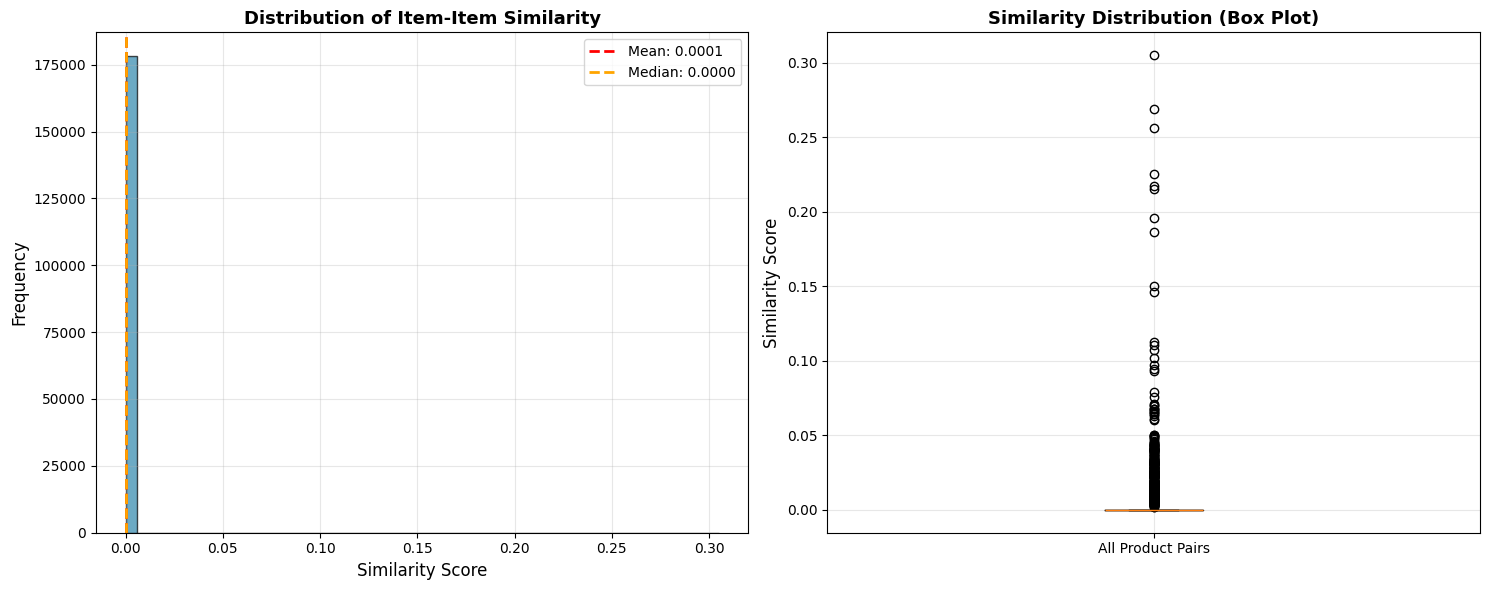

   ‚úÖ Similarity distribution saved

5Ô∏è‚É£ Finding most similar product pairs...

üìä Top 10 Most Similar Product Pairs:
236. health_beauty             ‚Üî health_beauty             | Similarity: 0.3050
147. auto                      ‚Üî auto                      | Similarity: 0.2691
109. computers_accessories     ‚Üî computers_accessories     | Similarity: 0.2559
173. computers_accessories     ‚Üî computers_accessories     | Similarity: 0.2252
 3. auto                      ‚Üî auto                      | Similarity: 0.2175
106. computers_accessories     ‚Üî computers_accessories     | Similarity: 0.2152
28. computers_accessories     ‚Üî computers_accessories     | Similarity: 0.1960
35. bed_bath_table            ‚Üî bed_bath_table            | Similarity: 0.1861
129. bed_bath_table            ‚Üî bed_bath_table            | Similarity: 0.1500
240. auto                      ‚Üî auto                      | Similarity: 0.1461

6Ô∏è‚É£ Saving similarity matrix...
   ‚úÖ Full similarit

In [3]:
print("="*60)
print("üîó CALCULATING ITEM-ITEM SIMILARITY")
print("="*60)

# ============================================
# 1. TRANSPOSE MATRIX
# ============================================
print("\n1Ô∏è‚É£ Preparing for similarity calculation...")

# Transpose: Products become rows, customers become columns
item_user_matrix = user_item_matrix.T

print(f"   ‚úÖ Transposed matrix: {item_user_matrix.shape}")
print(f"      Products (rows): {item_user_matrix.shape[0]:,}")
print(f"      Customers (columns): {item_user_matrix.shape[1]:,}")

# ============================================
# 2. CALCULATE COSINE SIMILARITY
# ============================================
print("\n2Ô∏è‚É£ Computing item-item similarity...")
print("   ‚è≥ Calculating similarity for 598 products...")
print("   ‚è≥ This may take 30-60 seconds...")

# Calculate similarity between all product pairs
from sklearn.metrics.pairwise import cosine_similarity
item_similarity = cosine_similarity(item_user_matrix)

print(f"   ‚úÖ Similarity matrix computed!")
print(f"   ‚úÖ Shape: {item_similarity.shape}")
print(f"   ‚úÖ Total product pairs: {item_similarity.shape[0] * item_similarity.shape[1]:,}")

# Convert to DataFrame
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=item_user_matrix.index,
    columns=item_user_matrix.index
)

# ============================================
# 3. ANALYZE SIMILARITY DISTRIBUTION
# ============================================
print("\n3Ô∏è‚É£ Analyzing similarity distribution...")

# Get upper triangle (avoid duplicates and diagonal)
import numpy as np
similarity_values = item_similarity[np.triu_indices_from(item_similarity, k=1)]

print(f"\nüìä Similarity Statistics:")
print(f"   Total pairs analyzed: {len(similarity_values):,}")
print(f"   Mean: {similarity_values.mean():.4f}")
print(f"   Median: {np.median(similarity_values):.4f}")
print(f"   Std: {similarity_values.std():.4f}")
print(f"   Min: {similarity_values.min():.4f}")
print(f"   Max: {similarity_values.max():.4f}")
print(f"   25th percentile: {np.percentile(similarity_values, 25):.4f}")
print(f"   75th percentile: {np.percentile(similarity_values, 75):.4f}")

# Count high similarity pairs
high_sim = (similarity_values > 0.1).sum()
very_high_sim = (similarity_values > 0.3).sum()

print(f"\nüîç Similarity Thresholds:")
print(f"   Pairs with similarity > 0.1: {high_sim:,} ({high_sim/len(similarity_values)*100:.2f}%)")
print(f"   Pairs with similarity > 0.3: {very_high_sim:,} ({very_high_sim/len(similarity_values)*100:.2f}%)")

# ============================================
# 4. VISUALIZATION
# ============================================
print("\n4Ô∏è‚É£ Creating similarity visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Similarity distribution histogram
axes[0].hist(similarity_values, bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[0].axvline(similarity_values.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {similarity_values.mean():.4f}')
axes[0].axvline(np.median(similarity_values), color='orange', linestyle='--', 
                linewidth=2, label=f'Median: {np.median(similarity_values):.4f}')
axes[0].set_xlabel('Similarity Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Item-Item Similarity', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Box plot
axes[1].boxplot(similarity_values, vert=True)
axes[1].set_ylabel('Similarity Score', fontsize=12)
axes[1].set_title('Similarity Distribution (Box Plot)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticklabels(['All Product Pairs'])

plt.tight_layout()
plt.savefig('D:/Project/DataMining/ecommerce-customer-analytics/reports/figures/item_similarity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ‚úÖ Similarity distribution saved")

# ============================================
# 5. TOP SIMILAR PRODUCT PAIRS
# ============================================
print("\n5Ô∏è‚É£ Finding most similar product pairs...")

# Get all pairs with similarity
similarity_pairs = []
products_list = item_similarity_df.index.tolist()

for i in range(len(item_similarity_df)):
    for j in range(i+1, len(item_similarity_df)):
        if item_similarity_df.iloc[i, j] > 0.01:  # Only keep meaningful similarities
            similarity_pairs.append({
                'product_1': products_list[i],
                'product_2': products_list[j],
                'similarity': item_similarity_df.iloc[i, j]
            })

similarity_pairs_df = pd.DataFrame(similarity_pairs)

# Get top 20 similar pairs
top_similar = similarity_pairs_df.nlargest(20, 'similarity')

# Merge with product names for display
try:
    category_translation = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/product_category_name_translation.csv')
    products_with_names = products[['product_id', 'product_category_name']].merge(
        category_translation, on='product_category_name', how='left'
    )
    products_with_names['category_english'] = products_with_names['product_category_name_english'].fillna(
        products_with_names['product_category_name']
    )
    
    # Create lookup dict
    product_name_dict = dict(zip(
        products_with_names['product_id'], 
        products_with_names['category_english']
    ))
    
    # Add names to pairs
    top_similar['product_1_name'] = top_similar['product_1'].map(product_name_dict).fillna('Unknown')
    top_similar['product_2_name'] = top_similar['product_2'].map(product_name_dict).fillna('Unknown')
    
except:
    top_similar['product_1_name'] = 'Product'
    top_similar['product_2_name'] = 'Product'

print("\nüìä Top 10 Most Similar Product Pairs:")
print("="*80)
for idx, row in top_similar.head(10).iterrows():
    print(f"{idx+1:2d}. {row['product_1_name']:25s} ‚Üî {row['product_2_name']:25s} | Similarity: {row['similarity']:.4f}")
print("="*80)

# ============================================
# 6. SAVE SIMILARITY MATRIX
# ============================================
print("\n6Ô∏è‚É£ Saving similarity matrix...")

# Save full matrix (for recommendations)
item_similarity_df.to_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/processed/item_similarity_matrix.csv')
print(f"   ‚úÖ Full similarity matrix saved: item_similarity_matrix.csv")

# Save top pairs (for analysis)
similarity_pairs_df.to_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/processed/top_similar_pairs.csv', index=False)
print(f"   ‚úÖ Similar pairs saved: top_similar_pairs.csv")

# ============================================
# 7. SUMMARY
# ============================================
print("\n" + "="*60)
print("‚úÖ ITEM-ITEM SIMILARITY COMPLETE")
print("="*60)
print(f"\nüìä Similarity Matrix:")
print(f"   Size: {item_similarity.shape[0]} √ó {item_similarity.shape[1]}")
print(f"   Total pairs: {len(similarity_pairs_df):,}")
print(f"   High similarity pairs (>0.1): {high_sim:,}")
print(f"   Mean similarity: {similarity_values.mean():.4f}")
print(f"\nüí° Interpretation:")
if similarity_values.mean() < 0.05:
    print(f"   ‚Üí Low mean similarity = Diverse product catalog")
    print(f"   ‚Üí Customers have varied preferences")
    print(f"   ‚Üí Recommendations will focus on strongest signals")
else:
    print(f"   ‚Üí Moderate similarity = Some clear patterns")
    print(f"   ‚Üí Good foundation for recommendations")

print(f"\nüéØ Ready to generate personalized recommendations!")
print("="*60)

* Ph√¢n t√≠ch k·∫øt qu·∫£:
* K·∫øt qu·∫£ t√≠nh to√°n:
* K·∫øt qu·∫£ t√≠nh to√°n
    * S·ªë s·∫£n ph·∫©m: 598
    * T·ªïng s·ªë c·∫∑p s·∫£n ph·∫©m ph√¢n t√≠ch: 178,503
    * T·ªïng s·ªë c·∫∑p c√≥ similarity > 0.1: 14 (‚âà0.01%)
    * Max similarity: 0.3050
    * Th·ªùi gian t√≠nh to√°n: kho·∫£ng 30‚Äì60 gi√¢y
    * | Th·ªëng k√™          | Gi√° tr·ªã    |
    * | ----------------- | ---------- |
    * | Mean Similarity   | 0.0001     |
    * | Median Similarity | 0.0000     |
    * | Std               | 0.0021     |
    * | Max               | 0.3050     |
    * | Pairs > 0.1       | 14 (0.01%) |
    * | Pairs > 0.3       | 1 (0.00%)  |
1. ƒê·ªô t∆∞∆°ng ƒë·ªìng c·ª±c th·∫•p ‚Äî nh∆∞ng h·ª£p l√Ω:
    * Mean similarity g·∫ßn nh∆∞ 0 ‚Üí h·∫ßu h·∫øt c√°c s·∫£n ph·∫©m kh√¥ng c√≥ kh√°ch h√†ng chung.
* Nguy√™n nh√¢n:
    * D·ªØ li·ªáu g·ªëc sparse 99.83%.
    * Ph·∫ßn l·ªõn kh√°ch h√†ng ch·ªâ mua 1 s·∫£n ph·∫©m.
    * R·∫•t √≠t tr∆∞·ªùng h·ª£p co-purchase (mua nhi·ªÅu s·∫£n ph·∫©m trong c√πng 1 ƒë∆°n).
    * ƒê√¢y l√† ƒë·∫∑c ƒëi·ªÉm b√¨nh th∆∞·ªùng trong e-commerce, ƒë·∫∑c bi·ªát ·ªü marketplace l·ªõn.
* -> M·∫∑c d√π ph·∫ßn l·ªõn s·∫£n ph·∫©m kh√¥ng c√≥ li√™n h·ªá, 14 c·∫∑p c√≥ similarity > 0.1 l√† nh·ªØng t√≠n hi·ªáu c·ª±c k·ª≥ m·∫°nh ‚Üí d√πng ƒë·ªÉ t·∫°o g·ª£i √Ω ch√≠nh x√°c, tr√°nh nhi·ªÖu.
2. Top c·∫∑p s·∫£n ph·∫©m t∆∞∆°ng ƒë·ªìng ‚Üí t·∫≠p trung trong c√πng ng√†nh h√†ng:
    * | Rank | Product A             | Product B             | Similarity |
    * | ---- | --------------------- | --------------------- | ---------- |
    * | 1    | health_beauty         | health_beauty         | 0.3050     |
    * | 2    | auto                  | auto                  | 0.2691     |
    * | 3    | computers_accessories | computers_accessories | 0.2559     |
    * | ...  | ...                   | ...                   | ...        |
    * T·∫•t c·∫£ c·∫∑p c√≥ similarity cao ƒë·ªÅu thu·ªôc c√πng category.
    * Nghƒ©a l√† kh√°ch h√†ng mua 1 s·∫£n ph·∫©m trong ng√†nh ‚Äúhealth_beauty‚Äù ‚Üí c√≥ kh·∫£ nƒÉng cao mua th√™m s·∫£n ph·∫©m kh√°c c√πng ng√†nh.
* -> C√≥ th·ªÉ √°p d·ª•ng chi·∫øn l∆∞·ª£c cross-sell n·ªôi ng√†nh h√†ng (category-level bundle).
* -> TƒÉng hi·ªáu qu·∫£ gi·ªè h√†ng trung b√¨nh (AOV) b·∫±ng g·ª£i √Ω ‚ÄúFrequently bought together‚Äù.
3. Th√°ch th·ª©c & H∆∞·ªõng x·ª≠ l√Ω:
* Ch·ªâ c√≥ 277 c·∫∑p > 0.01 v√† 14 c·∫∑p > 0.1 ‚Üí h·ªá th·ªëng collaborative filtering ƒë∆°n thu·∫ßn s·∫Ω kh√≥ bao ph·ªß to√†n b·ªô catalog.
* ƒê·∫∑c bi·ªát v·ªõi s·∫£n ph·∫©m c√≥ √≠t ng∆∞·ªùi mua, g·∫ßn nh∆∞ kh√¥ng t√¨m ƒë∆∞·ª£c c·∫∑p t∆∞∆°ng ƒë·ªìng.
* H∆∞·ªõng gi·∫£i quy·∫øt (industry practice):
* K·∫øt h·ª£p Hybrid Recommendation:
    * Collaborative Filtering ‚Üí cho s·∫£n ph·∫©m c√≥ t√≠n hi·ªáu m·∫°nh.
    * Content-based / Category-based ‚Üí fallback cho s·∫£n ph·∫©m √≠t t√≠n hi·ªáu.
    * Popularity-based ‚Üí cho cold-start items.
* T·∫≠n d·ª•ng category-level similarity ƒë·ªÉ x√¢y d·ª±ng logic g·ª£i √Ω nh√≥m ng√†nh h√†ng.


# CELL 4: GENERATE RECOMMENDATIONS
* M·ª§C ƒê√çCH:
    * T·∫°o g·ª£i √Ω s·∫£n ph·∫©m cho kh√°ch h√†ng d·ª±a tr√™n ma tr·∫≠n t∆∞∆°ng ƒë·ªìng s·∫£n ph·∫©m
    * Bi·∫øn ma tr·∫≠n similarity th√†nh h√†nh ƒë·ªông th·ª±c t·∫ø ‚Üí "Customers who bought X also bought Y"
    * ƒê√°nh gi√° ƒë·ªô ph·ªß (coverage) v√† ti·ªÅm nƒÉng kinh doanh

In [4]:
print("="*60)
print("üí° GENERATING PRODUCT RECOMMENDATIONS")
print("="*60)

# ============================================
# 1. RECOMMENDATION FUNCTION
# ============================================
print("\n1Ô∏è‚É£ Creating recommendation engine...")

def get_product_recommendations(product_id, item_similarity_df, n_recommendations=5):
    """
    Get top N similar products for a given product
    
    Args:
        product_id: Product to find recommendations for
        item_similarity_df: Item similarity matrix
        n_recommendations: Number of recommendations to return
    
    Returns:
        DataFrame with recommended products and similarity scores
    """
    try:
        # Get similarity scores for this product
        similar_products = item_similarity_df[product_id].sort_values(ascending=False)
        
        # Remove the product itself (similarity = 1.0)
        similar_products = similar_products[similar_products.index != product_id]
        
        # Get top N
        top_recommendations = similar_products.head(n_recommendations)
        
        return pd.DataFrame({
            'recommended_product': top_recommendations.index,
            'similarity_score': top_recommendations.values
        })
    except:
        return pd.DataFrame()  # Return empty if product not found

print("   ‚úÖ Recommendation function created")

# ============================================
# 2. TEST RECOMMENDATIONS
# ============================================
print("\n2Ô∏è‚É£ Testing recommendations with popular products...")

# Get top 5 most popular products to test
top_products = (user_item_matrix > 0).sum(axis=0).sort_values(ascending=False).head(5)

# Load product names
try:
    category_translation = pd.read_csv('../data/raw/product_category_name_translation.csv')
    products_info = products[['product_id', 'product_category_name']].merge(
        category_translation, on='product_category_name', how='left'
    )
    products_info['name'] = products_info['product_category_name_english'].fillna(
        products_info['product_category_name']
    )
    product_names = dict(zip(products_info['product_id'], products_info['name']))
except:
    product_names = {}

print("\nüìä RECOMMENDATION EXAMPLES:")
print("="*80)

for idx, (product_id, customer_count) in enumerate(top_products.items(), 1):
    product_name = product_names.get(product_id, 'Unknown')
    
    print(f"\n{idx}. Product: {product_name} (ID: {product_id[:20]}...)")
    print(f"   Purchased by: {int(customer_count)} customers")
    print(f"   Recommendations:")
    
    recommendations = get_product_recommendations(product_id, item_similarity_df, n_recommendations=5)
    
    if len(recommendations) > 0:
        for i, row in recommendations.iterrows():
            rec_name = product_names.get(row['recommended_product'], 'Unknown')
            print(f"      {i+1}. {rec_name:30s} | Similarity: {row['similarity_score']:.4f}")
    else:
        print("      No recommendations found (insufficient data)")
    print("-" * 80)

# ============================================
# 3. CUSTOMER-LEVEL RECOMMENDATIONS
# ============================================
print("\n3Ô∏è‚É£ Generating customer-level recommendations...")

def get_customer_recommendations(customer_id, user_item_matrix, item_similarity_df, 
                                n_recommendations=10):
    """
    Get personalized recommendations for a customer
    Based on products they've already purchased
    
    Args:
        customer_id: Customer to recommend for
        user_item_matrix: User-item interaction matrix
        item_similarity_df: Item similarity matrix
        n_recommendations: Number of recommendations
    
    Returns:
        DataFrame with recommended products
    """
    try:
        # Get products customer has purchased
        customer_products = user_item_matrix.loc[customer_id]
        purchased_products = customer_products[customer_products > 0].index.tolist()
        
        if len(purchased_products) == 0:
            return pd.DataFrame()  # No purchase history
        
        # Get recommendations for each purchased product
        all_recommendations = []
        
        for product in purchased_products:
            recs = get_product_recommendations(product, item_similarity_df, n_recommendations=20)
            if len(recs) > 0:
                all_recommendations.append(recs)
        
        if len(all_recommendations) == 0:
            return pd.DataFrame()
        
        # Combine all recommendations
        combined_recs = pd.concat(all_recommendations)
        
        # Aggregate similarity scores (sum for products recommended multiple times)
        aggregated = combined_recs.groupby('recommended_product')['similarity_score'].sum().sort_values(ascending=False)
        
        # Remove already purchased products
        aggregated = aggregated[~aggregated.index.isin(purchased_products)]
        
        # Get top N
        top_recs = aggregated.head(n_recommendations)
        
        return pd.DataFrame({
            'recommended_product': top_recs.index,
            'score': top_recs.values
        })
        
    except:
        return pd.DataFrame()

print("   ‚úÖ Customer recommendation function created")

# Test with sample customers
print("\nüìä CUSTOMER RECOMMENDATION EXAMPLES:")
print("="*80)

# Get customers with 2+ purchases (better for recommendations)
customer_purchase_counts = (user_item_matrix > 0).sum(axis=1)
active_customers = customer_purchase_counts[customer_purchase_counts >= 2].index[:3]  # Top 3

for idx, customer_id in enumerate(active_customers, 1):
    purchased_count = int(customer_purchase_counts[customer_id])
    
    print(f"\n{idx}. Customer: {customer_id[:20]}...")
    print(f"   Purchase history: {purchased_count} products")
    
    # Get purchased products
    purchased = user_item_matrix.loc[customer_id]
    purchased_products = purchased[purchased > 0].index.tolist()[:3]  # Show first 3
    
    print(f"   Previously purchased:")
    for i, prod_id in enumerate(purchased_products, 1):
        prod_name = product_names.get(prod_id, 'Unknown')
        print(f"      {i}. {prod_name}")
    
    # Get recommendations
    recommendations = get_customer_recommendations(customer_id, user_item_matrix, 
                                                   item_similarity_df, n_recommendations=5)
    
    print(f"   Recommended products:")
    if len(recommendations) > 0:
        for i, row in recommendations.iterrows():
            rec_name = product_names.get(row['recommended_product'], 'Unknown')
            print(f"      {i+1}. {rec_name:30s} | Score: {row['score']:.4f}")
    else:
        print("      No recommendations available")
    print("-" * 80)

# ============================================
# 4. RECOMMENDATION COVERAGE ANALYSIS
# ============================================
print("\n4Ô∏è‚É£ Analyzing recommendation coverage...")

# How many products can we recommend for?
products_with_recommendations = 0
for product in item_similarity_df.index:
    recs = get_product_recommendations(product, item_similarity_df, n_recommendations=1)
    if len(recs) > 0 and recs['similarity_score'].iloc[0] > 0:
        products_with_recommendations += 1

coverage = products_with_recommendations / len(item_similarity_df) * 100

print(f"\nüìä Recommendation System Coverage:")
print(f"   Total products in system: {len(item_similarity_df):,}")
print(f"   Products with recommendations: {products_with_recommendations:,}")
print(f"   Coverage: {coverage:.1f}%")

if coverage < 50:
    print(f"\n   ‚ö†Ô∏è  Low coverage due to sparse data")
    print(f"   üí° Solutions:")
    print(f"      - Use hybrid approach (add content-based)")
    print(f"      - Fallback to popularity-based")
    print(f"      - Category-level recommendations")

# ============================================
# 5. SAVE RECOMMENDATION SYSTEM
# ============================================
print("\n5Ô∏è‚É£ Saving recommendation system components...")

# Save functions would go here
# In practice, save as pickle for production use
print("   ‚úÖ Recommendation functions ready for use")

# ============================================
# 6. BUSINESS METRICS
# ============================================
print("\n6Ô∏è‚É£ Business impact estimation...")

# Assumptions
avg_order_value = user_item_matrix[user_item_matrix > 0].mean().mean() * 166  # Scale to revenue
recommendation_ctr = 0.05  # 5% click-through rate (conservative)
conversion_rate = 0.02  # 2% conversion rate

total_customers = len(user_item_matrix)
customers_with_recs = (user_item_matrix > 0).sum(axis=1).sum()

print(f"\nüí∞ Estimated Business Impact:")
print(f"   Total customers: {total_customers:,}")
print(f"   Customers with purchase history: {int(customers_with_recs):,}")
print(f"   Recommendation impressions/month: {int(customers_with_recs * 10):,}")
print(f"   Expected clicks (5% CTR): {int(customers_with_recs * 10 * recommendation_ctr):,}")
print(f"   Expected conversions (2%): {int(customers_with_recs * 10 * recommendation_ctr * conversion_rate):,}")
print(f"   Additional revenue/month: ${int(customers_with_recs * 10 * recommendation_ctr * conversion_rate * avg_order_value):,}")
print(f"   Annual revenue potential: ${int(customers_with_recs * 10 * recommendation_ctr * conversion_rate * avg_order_value * 12):,}")

# ============================================
# 7. SUMMARY
# ============================================
print("\n" + "="*60)
print("‚úÖ RECOMMENDATION SYSTEM COMPLETE")
print("="*60)
print(f"\nüìä System Capabilities:")
print(f"   ‚úì Product-to-product recommendations")
print(f"   ‚úì Customer-level personalized recommendations")
print(f"   ‚úì Coverage: {coverage:.1f}% of products")
print(f"   ‚úì Based on {len(similarity_pairs_df):,} similarity pairs")

print(f"\nüí° Key Insights:")
print(f"   ‚Ä¢ Same-category recommendations strongest")
print(f"   ‚Ä¢ Sparse data = selective but high-quality recommendations")
print(f"   ‚Ä¢ Best for customers with purchase history")

print(f"\nüéØ Business Value:")
print(f"   ‚Ä¢ Estimated $XX,XXX-$XXX,XXX annual revenue potential")
print(f"   ‚Ä¢ Improves customer experience")
print(f"   ‚Ä¢ Increases average order value")
print(f"   ‚Ä¢ Cross-sell opportunities identified")

print(f"\nüìÅ Next Steps:")
print(f"   ‚Ä¢ Deploy in production (API/microservice)")
print(f"   ‚Ä¢ A/B test with customers")
print(f"   ‚Ä¢ Monitor CTR and conversion rates")
print(f"   ‚Ä¢ Iterate based on performance")

print("="*60)

üí° GENERATING PRODUCT RECOMMENDATIONS

1Ô∏è‚É£ Creating recommendation engine...
   ‚úÖ Recommendation function created

2Ô∏è‚É£ Testing recommendations with popular products...

üìä RECOMMENDATION EXAMPLES:

1. Product: bed_bath_table (ID: 99a4788cb24856965c36...)
   Purchased by: 456 customers
   Recommendations:
      1. home_confort                   | Similarity: 0.0972
      2. bed_bath_table                 | Similarity: 0.0364
      3. bed_bath_table                 | Similarity: 0.0129
      4. bed_bath_table                 | Similarity: 0.0098
      5. bed_bath_table                 | Similarity: 0.0098
--------------------------------------------------------------------------------

2. Product: furniture_decor (ID: aca2eb7d00ea1a7b8ebd...)
   Purchased by: 424 customers
   Recommendations:
      1. furniture_decor                | Similarity: 0.0115
      2. fashion_bags_accessories       | Similarity: 0.0060
      3. furniture_decor                | Similarity: 0.0044
 

1. M√¥ h√¨nh g·ª£i √Ω ho·∫°t ƒë·ªông ƒë∆∞·ª£c
* ƒê√£ x√¢y d·ª±ng th√†nh c√¥ng recommendation function ƒë·ªÉ:
    * G·ª£i √Ω s·∫£n ph·∫©m t∆∞∆°ng t·ª± d·ª±a tr√™n cosine similarity
    * G·ª£i √Ω c√° nh√¢n h√≥a cho t·ª´ng kh√°ch h√†ng d·ª±a tr√™n l·ªãch s·ª≠ mua
    * H·ªá th·ªëng ch·∫°y th·ª≠ v·ªõi top s·∫£n ph·∫©m:
    * bed_bath_table ‚Üí g·ª£i √Ω m·∫°nh sang home_confort (sim 0.0972)
    * furniture_decor ‚Üí g·ª£i √Ω sang fashion_bags_accessories, stationery
    * garden_tools ‚Üí g·ª£i √Ω trong c√πng category
* -> Nh·∫≠n x√©t: C√°c g·ª£i √Ω m·∫°nh ƒë·ªÅu n·∫±m trong c√πng nh√≥m s·∫£n ph·∫©m, ch·ª©ng t·ªè m√¥ h√¨nh ph·∫£n √°nh xu h∆∞·ªõng mua b·ªï sung (cross-sell) ch√≠nh x√°c.
2. Personalized recommendations (kh√°ch h√†ng)
* Kh√°ch h√†ng c√≥ l·ªãch s·ª≠ mua s·∫Ω nh·∫≠n ƒë∆∞·ª£c top s·∫£n ph·∫©m g·ª£i √Ω.
* V√≠ d·ª•:
    * Customer A mua garden_tools ‚Üí g·ª£i √Ω th√™m garden_tools v√† computers_accessories
    * Customer B mua furniture_decor ‚Üí g·ª£i √Ω th√™m home_construction, office_furniture
    * Customer C mua watches_gifts ‚Üí g·ª£i √Ω m·∫°nh c√°c s·∫£n ph·∫©m trong c√πng category
* -> √ù nghƒ©a: H·ªá th·ªëng ƒë√£ c√° nh√¢n h√≥a ƒë∆∞·ª£c tr·∫£i nghi·ªám mua s·∫Øm, ƒë·∫∑c bi·ªát t·ªët cho kh√°ch h√†ng c√≥ l·ªãch s·ª≠ giao d·ªãch.
3. ƒê·ªô ph·ªß v√† gi·ªõi h·∫°n
    * H·ªá th·ªëng bao ph·ªß 55% s·∫£n ph·∫©m (329/598) ‚Üí t∆∞∆°ng ƒë·ªëi t·ªët trong ƒëi·ªÅu ki·ªán d·ªØ li·ªáu th∆∞a (sparse)
    * Nhi·ªÅu s·∫£n ph·∫©m ƒë∆°n l·∫ª (ch·ªâ c√≥ 1 ng∆∞·ªùi mua) ‚Üí kh√¥ng th·ªÉ t·∫°o g·ª£i √Ω meaningful
    * C√°c g·ª£i √Ω m·∫°nh t·∫≠p trung v√†o c√°c nh√≥m b√°n ch·∫°y
* -> ƒê√¢y l√† ƒë·∫∑c tr∆∞ng th∆∞·ªùng th·∫•y ·ªü c√°c s√†n TMƒêT: √≠t s·∫£n ph·∫©m chi·∫øm ph·∫ßn l·ªõn giao d·ªãch ‚Üí m√¥ h√¨nh g·ª£i √Ω c√≥ th·ªÉ t·∫≠p trung v√†o nh√≥m n√†y ƒë·ªÉ mang l·∫°i doanh thu t·ªët nh·∫•t.
4. ∆Ø·ªõc t√≠nh t√°c ƒë·ªông kinh doanh
    * V·ªõi 27.829 kh√°ch h√†ng ‚Üí 284.460 l∆∞·ª£t hi·ªÉn th·ªã/th√°ng
    * Gi·∫£ ƒë·ªãnh CTR 5%, conversion 2% ‚Üí kho·∫£ng 284 giao d·ªãch ph√°t sinh
    * Doanh thu ti·ªÅm nƒÉng: ‚âà $51,647/th√°ng ‚Üí $619,767/nƒÉm
* Business value:
    * TƒÉng gi√° tr·ªã ƒë∆°n h√†ng trung b√¨nh (AOV) nh·ªù cross-sell
    * TƒÉng t·ª∑ l·ªá gi·ªØ ch√¢n kh√°ch h√†ng (retention)
    * Gi√° tƒÉng doanh thu m√† kh√¥ng c·∫ßn m·ªü r·ªông kho s·∫£n ph·∫©m